# Learning Tensorflow

I will teach myself how to use tensorflow and will document that process in this notebook. I am trying to go thru as much as I can of the official guide: https://www.tensorflow.org/guide. Nothing here is original, it's just going thru the guide and explaining what's going on in my own words. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

## Tensors and Variables

Tensors are a fancy name for n-dimensional arrays. The # of dimensions is called the rank. A 1-dimensional array, like [5], is a tensor with rank 1. A tensor [[2,3],[4,1]] has rank 2 and dimensions (2,2). 

The main types of Tensors are:  
tf.Variable  
tf.constant  
tf.placeholder  
tf.SparseTensor  

Except for tf.Variable, they are all immutable within the execution of a session. Elements of a Tensor must all be the same datatype and can be quite varied. tf.Variables can exist outside the context of a single session.run call, which is not true of other tf.Tensors. 

In [ ]:
a = tf.Variable([[5.0],[2.0],[3]])
b = tf.Variable([[5,1],[2,1],[3,3]], tf.int32)
c = tf.Variable(['Hello','World'], tf.string)
print(a,b,c)
print(tf.rank(a), tf.rank(b), tf.rank(c))
print(b[2])
print(b[2,0])


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(c))

All variables get added to two collections:  
tf.GraphKeys.GLOBAL_VARIABLES - variables that can be shared across devices  
tf.GraphKeys.TRAINABLE_VARIABLES - variables for which Tensorflow will calculate gradients  
Collections are a way to group variables that may not be connected in the graph. You can make your own collection by just adding a variable to it. You can also place variables on particular devices. 

In [ ]:
#proper way to create a variable
if not my_var:
    my_var = tf.get_variable("my_var", [1,2,3])
print(my_var)

#add it to a collection
tf.add_to_collection("my_collection", my_var)
print(tf.get_collection("my_collection"))

#adding my_var to device
with tf.device("/device:CPU:0"):
    if not v:
        v = tf.get_variable("v", [2,2])
    
#prints available devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#convert different objects to tensors
np_array = np.zeros((40,3))
some_list = [[1,2,3,4],[2,5,1,1]]
np_tensor = tf.convert_to_tensor(np_array)
list_tensor = tf.convert_to_tensor(some_list)
print(np_tensor)
print(list_tensor)

An interesting feature here is that you can specify the scope in which variables are created. For example, variables created within function do *not* just live within the scope of the function. This allows you to reuse those variables elsewhere. 

In [ ]:
def some_operation(x):
    w = tf.get_variable("w", [2,2], initializer=tf.random_normal_initializer())
    return w + x

x = tf.random_normal([2,2])
y = some_operation(x)
try:
    z = some_operation(y)
except ValueError:
    print('did not like this')
    
with tf.variable_scope("one"):
    y = some_operation(x)
with tf.variable_scope("two"):
    z = some_operation(y)
    print('function ran on a different scope, this it liked')

## Graphs and Sessions
A tensorflow program consists of a computational graph and a session, which runs the graph. The word graph is meant in the discrete math graph theory sense. A graph consists of nodes and vertices. Vertices are tensors, i.e. arrays, which flow thru nodes, which are operations. So arrays pass thru nodes where they are operated upon, and the output tensor may flow elsewhere to be further processed. Below we define a simple graph with 1-dimensional tensors (constants), and a node that adds them together.  

In [ ]:
a = tf.constant(3.0, dtype=tf.float32)
b = tf.constant(4.0) # also tf.float32 implicitly
total = a + b
print(a)
print(b)
print(total)

The computational graph has just been defined *but not* run. That is why total doesn't say 7.  

OK, now we define a session. The session takes three optional arguments:  
1) target - default uses devices only on local machine, whilst grpc:// allows you to use a remote TensorFlow server  
2) graph - it operates on the default graph but you can specify which graph you want it to operate on
3) config - bunch of states which alter the way the graph is computed

The tf.Session.run method is how you compute parts of the graph. You can put any number of nodes or edges you want to compute. Does not have to be the whole graph.  

In [ ]:
sess = tf.Session()
print(sess.run(total))
print(sess.run({'ab':(a,b), 'total':total, 'sandwhich': (b,total)}))


vec = tf.random_uniform(shape=(3,))
out1 = vec + 1
out2 = vec + 2
#different values between the first 2
print(sess.run(vec))
print(sess.run(vec))
#this time, vec is run once as part of the same graph
print(sess.run((out1, out2)))


In [ ]:
#this is kind of like a function z(x,y) = x+y
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
z = x + y

print(sess.run(z, feed_dict={x:3, y:5}))
print(sess.run(z, feed_dict={x:[1,2,1,1,1], y:[2,-1,4,-5,4]}))

In [ ]:
'''
datasets are preferred over placeholders. basically you take a "dataset" and iterate over some dimension
'''
my_data = [
    [0, 1,],
    [2, 3,],
    [4, 5,],
    [6, 7,],
]
slices = tf.data.Dataset.from_tensor_slices(my_data)
print(slices)
next_item = slices.make_one_shot_iterator().get_next()
print(next_item)
while True:
  try:
    print(sess.run(next_item))
  except tf.errors.OutOfRangeError:
    break


OK. I get how we are making the slices and iterate over them with a generator-like way. At the end it throws an OutOfRange exception and that's your cue to break. I don't like these, the methods have ugly names, haha. It seems unnecessarily complicated but I'm sure I'll realize later why they did it this way. Let's just carry on.  

## Layers
Layers combine both variables and the operations that act on them. In a neural network, a densely-connected layer will perform a weighted sum of the inputs and then apply a thresholding function.

In [ ]:
#Vertex in graph
x = tf.placeholder(tf.float32, shape=(None,3))
linear_model = tf.layers.Dense(units=2)
#default activation is linear, i.e. identity
print(linear_model.activation)

#the internal matrix is instantiated once the input is known
print('before putting input in:', linear_model.weights)
y = linear_model(x)
print('after putting input in:', linear_model.weights)


init = tf.global_variables_initializer()
sess.run(init)

print(sess.run(y, {x:[[1,2,3],[4,5,6]]}))

In [ ]:
'''
lets define a simple linear regression with the building blocks we just discovered
'''

#define some data
x = tf.constant([[1],[2],[3],[4]], dtype=tf.float32)
y_true = tf.constant([[0],[-2],[-2],[-3]], dtype=tf.float32)

#define model
linear_model = tf.layers.Dense(units=1)
y_pred = linear_model(x)

#run graph
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
print(sess.run(y_pred))

#define loss
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)
print('mse: ', sess.run(loss))

#define optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

for i in range(100):
    _, loss_val = sess.run((train, loss))
    
print('after training', sess.run(y_pred))



## Tensorboard
We will visualize the graph using TensorBoard. This will be useful for the work we may do with Kanaka. 

In [ ]:
writer = tf.summary.FileWriter('/Users/pablomartin/python/tensorflow/graphs/')
writer.add_graph(tf.get_default_graph())

Code above wrote a file to given directory. It must be opened with the following command:  

python -m tensorboard.main --logdir=tensorflow/graphs/    

Then we can view the graph on a browser. There are ways to specify which part of the graph to show or not, but until we know what we want, let's just leave it at that. 

## Keras 
I am following the tensorflow guide on keras here. First we build a multi-layer perceptron:

In [3]:
from tensorflow import keras

model = keras.Sequential()
#very similar to regular keras
model.add(keras.layers.Dense(64, activation='relu'))
#by default, no activation is applied, so you must specify something
model.add(keras.layers.Dense(64, activation='relu'))
#softmax layers to categorize into one of 10 categories
model.add(keras.layers.Dense(10, activation='softmax'))
#again very similar, you have to specify learning rate on optimizer though
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])


In [4]:
#fitting some random data
data = np.random.random((1000, 32))
labels = np.random.random((1000, 10))

val_data = np.random.random((100, 32))
val_labels = np.random.random((100, 10))

History = model.fit(data, labels, epochs=1000, batch_size=32,
          validation_data=(val_data, val_labels))
print(History)

Train on 1000 samples, validate on 100 samples
Epoch 1/1000
1000/1000 [==============================] - 0s 394us/step - loss: 11.6982 - acc: 0.1090 - val_loss: 11.3536 - val_acc: 0.0700
Epoch 2/1000
1000/1000 [==============================] - 0s 42us/step - loss: 11.6676 - acc: 0.0940 - val_loss: 11.3480 - val_acc: 0.0700
Epoch 3/1000
1000/1000 [==============================] - 0s 43us/step - loss: 11.6603 - acc: 0.1160 - val_loss: 11.3442 - val_acc: 0.0700
Epoch 4/1000
1000/1000 [==============================] - 0s 42us/step - loss: 11.6548 - acc: 0.1200 - val_loss: 11.3435 - val_acc: 0.0300
Epoch 5/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.6506 - acc: 0.1310 - val_loss: 11.3453 - val_acc: 0.0700
Epoch 6/1000
1000/1000 [==============================] - 0s 43us/step - loss: 11.6454 - acc: 0.1460 - val_loss: 11.3476 - val_acc: 0.0700
Epoch 7/1000
1000/1000 [==============================] - 0s 42us/step - loss: 11.6415 - acc: 0.1450 - val_loss: 11.34

Epoch 59/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.4108 - acc: 0.3020 - val_loss: 11.4698 - val_acc: 0.1900
Epoch 60/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.4088 - acc: 0.3030 - val_loss: 11.4790 - val_acc: 0.1900
Epoch 61/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.4022 - acc: 0.2930 - val_loss: 11.4768 - val_acc: 0.1800
Epoch 62/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.4003 - acc: 0.3090 - val_loss: 11.4902 - val_acc: 0.2100
Epoch 63/1000
1000/1000 [==============================] - 0s 41us/step - loss: 11.3939 - acc: 0.3190 - val_loss: 11.4968 - val_acc: 0.2000
Epoch 64/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.3957 - acc: 0.2990 - val_loss: 11.4914 - val_acc: 0.1800
Epoch 65/1000
1000/1000 [==============================] - 0s 41us/step - loss: 11.3893 - acc: 0.3060 - val_loss: 11.4930 - val_acc: 0.1800
Epoch 66/1000
1000/1

1000/1000 [==============================] - 0s 45us/step - loss: 11.2660 - acc: 0.3580 - val_loss: 11.6786 - val_acc: 0.1300
Epoch 118/1000
1000/1000 [==============================] - 0s 45us/step - loss: 11.2692 - acc: 0.3610 - val_loss: 11.6742 - val_acc: 0.1500
Epoch 119/1000
1000/1000 [==============================] - 0s 49us/step - loss: 11.2639 - acc: 0.3620 - val_loss: 11.6719 - val_acc: 0.1300
Epoch 120/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.2607 - acc: 0.3750 - val_loss: 11.6684 - val_acc: 0.1300
Epoch 121/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.2590 - acc: 0.3720 - val_loss: 11.6817 - val_acc: 0.1100
Epoch 122/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.2615 - acc: 0.3620 - val_loss: 11.6696 - val_acc: 0.1500
Epoch 123/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.2570 - acc: 0.3870 - val_loss: 11.6984 - val_acc: 0.1200
Epoch 124/1000
1000/1000 [==

1000/1000 [==============================] - 0s 44us/step - loss: 11.1895 - acc: 0.4040 - val_loss: 11.8357 - val_acc: 0.1200
Epoch 176/1000
1000/1000 [==============================] - 0s 43us/step - loss: 11.1870 - acc: 0.4200 - val_loss: 11.8314 - val_acc: 0.1500
Epoch 177/1000
1000/1000 [==============================] - 0s 45us/step - loss: 11.1840 - acc: 0.4200 - val_loss: 11.8403 - val_acc: 0.1200
Epoch 178/1000
1000/1000 [==============================] - 0s 43us/step - loss: 11.1854 - acc: 0.4130 - val_loss: 11.8533 - val_acc: 0.1300
Epoch 179/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.1832 - acc: 0.4070 - val_loss: 11.8514 - val_acc: 0.1200
Epoch 180/1000
1000/1000 [==============================] - 0s 37us/step - loss: 11.1808 - acc: 0.4200 - val_loss: 11.8605 - val_acc: 0.1600
Epoch 181/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.1827 - acc: 0.4220 - val_loss: 11.8651 - val_acc: 0.1400
Epoch 182/1000
1000/1000 [==

Epoch 233/1000
1000/1000 [==============================] - 0s 49us/step - loss: 11.1357 - acc: 0.4310 - val_loss: 12.0227 - val_acc: 0.1400
Epoch 234/1000
1000/1000 [==============================] - 0s 42us/step - loss: 11.1344 - acc: 0.4420 - val_loss: 12.0088 - val_acc: 0.1400
Epoch 235/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.1326 - acc: 0.4440 - val_loss: 12.0135 - val_acc: 0.1600
Epoch 236/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.1320 - acc: 0.4460 - val_loss: 12.0114 - val_acc: 0.1500
Epoch 237/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.1303 - acc: 0.4580 - val_loss: 12.0045 - val_acc: 0.1500
Epoch 238/1000
1000/1000 [==============================] - 0s 41us/step - loss: 11.1307 - acc: 0.4510 - val_loss: 12.0200 - val_acc: 0.1400
Epoch 239/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.1288 - acc: 0.4290 - val_loss: 12.0427 - val_acc: 0.1300
Epoch 240/100

1000/1000 [==============================] - 0s 38us/step - loss: 11.0984 - acc: 0.4700 - val_loss: 12.1371 - val_acc: 0.1600
Epoch 292/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.0997 - acc: 0.4740 - val_loss: 12.1302 - val_acc: 0.1300
Epoch 293/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0979 - acc: 0.4640 - val_loss: 12.1441 - val_acc: 0.1800
Epoch 294/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0981 - acc: 0.4660 - val_loss: 12.1276 - val_acc: 0.1600
Epoch 295/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0980 - acc: 0.4640 - val_loss: 12.1166 - val_acc: 0.1700
Epoch 296/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0944 - acc: 0.4630 - val_loss: 12.1370 - val_acc: 0.1700
Epoch 297/1000
1000/1000 [==============================] - 0s 37us/step - loss: 11.0978 - acc: 0.4690 - val_loss: 12.1153 - val_acc: 0.1700
Epoch 298/1000
1000/1000 [==

1000/1000 [==============================] - 0s 45us/step - loss: 11.0727 - acc: 0.4880 - val_loss: 12.2230 - val_acc: 0.1600
Epoch 350/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.0718 - acc: 0.4930 - val_loss: 12.2360 - val_acc: 0.1500
Epoch 351/1000
1000/1000 [==============================] - 0s 37us/step - loss: 11.0731 - acc: 0.4830 - val_loss: 12.2184 - val_acc: 0.1800
Epoch 352/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0733 - acc: 0.4830 - val_loss: 12.2384 - val_acc: 0.1600
Epoch 353/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0736 - acc: 0.4910 - val_loss: 12.2429 - val_acc: 0.1500
Epoch 354/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0702 - acc: 0.4890 - val_loss: 12.2246 - val_acc: 0.1500
Epoch 355/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0723 - acc: 0.4890 - val_loss: 12.2407 - val_acc: 0.1400
Epoch 356/1000
1000/1000 [==

1000/1000 [==============================] - 0s 40us/step - loss: 11.0541 - acc: 0.5050 - val_loss: 12.3293 - val_acc: 0.1700
Epoch 408/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0554 - acc: 0.5170 - val_loss: 12.3534 - val_acc: 0.1300
Epoch 409/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0541 - acc: 0.4990 - val_loss: 12.3374 - val_acc: 0.1500
Epoch 410/1000
1000/1000 [==============================] - 0s 37us/step - loss: 11.0560 - acc: 0.4990 - val_loss: 12.3525 - val_acc: 0.1400
Epoch 411/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0523 - acc: 0.5050 - val_loss: 12.3538 - val_acc: 0.1800
Epoch 412/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0520 - acc: 0.5000 - val_loss: 12.3475 - val_acc: 0.1500
Epoch 413/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0522 - acc: 0.5010 - val_loss: 12.3499 - val_acc: 0.1500
Epoch 414/1000
1000/1000 [==

Epoch 465/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0393 - acc: 0.5060 - val_loss: 12.4394 - val_acc: 0.1400
Epoch 466/1000
1000/1000 [==============================] - 0s 37us/step - loss: 11.0383 - acc: 0.5090 - val_loss: 12.4622 - val_acc: 0.1100
Epoch 467/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0402 - acc: 0.5140 - val_loss: 12.4698 - val_acc: 0.1300
Epoch 468/1000
1000/1000 [==============================] - 0s 41us/step - loss: 11.0404 - acc: 0.5150 - val_loss: 12.4511 - val_acc: 0.1000
Epoch 469/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0359 - acc: 0.4900 - val_loss: 12.4590 - val_acc: 0.0900
Epoch 470/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0375 - acc: 0.5270 - val_loss: 12.4609 - val_acc: 0.1200
Epoch 471/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0355 - acc: 0.5180 - val_loss: 12.4640 - val_acc: 0.1100
Epoch 472/100

1000/1000 [==============================] - 0s 38us/step - loss: 11.0241 - acc: 0.5260 - val_loss: 12.5952 - val_acc: 0.0900
Epoch 524/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0240 - acc: 0.5090 - val_loss: 12.5781 - val_acc: 0.1200
Epoch 525/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0259 - acc: 0.5280 - val_loss: 12.5983 - val_acc: 0.1100
Epoch 526/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0230 - acc: 0.5210 - val_loss: 12.5563 - val_acc: 0.1300
Epoch 527/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0224 - acc: 0.5340 - val_loss: 12.5697 - val_acc: 0.1300
Epoch 528/1000
1000/1000 [==============================] - 0s 38us/step - loss: 11.0244 - acc: 0.5280 - val_loss: 12.5789 - val_acc: 0.1200
Epoch 529/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0233 - acc: 0.5390 - val_loss: 12.5692 - val_acc: 0.0900
Epoch 530/1000
1000/1000 [==

1000/1000 [==============================] - 0s 40us/step - loss: 11.0112 - acc: 0.5390 - val_loss: 12.6806 - val_acc: 0.1000
Epoch 582/1000
1000/1000 [==============================] - 0s 39us/step - loss: 11.0127 - acc: 0.5390 - val_loss: 12.6895 - val_acc: 0.1100
Epoch 583/1000
1000/1000 [==============================] - 0s 42us/step - loss: 11.0135 - acc: 0.5450 - val_loss: 12.6850 - val_acc: 0.1000
Epoch 584/1000
1000/1000 [==============================] - 0s 49us/step - loss: 11.0148 - acc: 0.5180 - val_loss: 12.6779 - val_acc: 0.1100
Epoch 585/1000
1000/1000 [==============================] - 0s 41us/step - loss: 11.0120 - acc: 0.5470 - val_loss: 12.6758 - val_acc: 0.1300
Epoch 586/1000
1000/1000 [==============================] - 0s 43us/step - loss: 11.0093 - acc: 0.5290 - val_loss: 12.6782 - val_acc: 0.1100
Epoch 587/1000
1000/1000 [==============================] - 0s 42us/step - loss: 11.0099 - acc: 0.5320 - val_loss: 12.6964 - val_acc: 0.1300
Epoch 588/1000
1000/1000 [==

1000/1000 [==============================] - 0s 44us/step - loss: 11.0007 - acc: 0.5600 - val_loss: 12.7445 - val_acc: 0.0800
Epoch 640/1000
1000/1000 [==============================] - 0s 42us/step - loss: 11.0065 - acc: 0.5480 - val_loss: 12.7609 - val_acc: 0.1200
Epoch 641/1000
1000/1000 [==============================] - 0s 41us/step - loss: 11.0031 - acc: 0.5520 - val_loss: 12.7641 - val_acc: 0.0800
Epoch 642/1000
1000/1000 [==============================] - 0s 41us/step - loss: 11.0023 - acc: 0.5500 - val_loss: 12.7577 - val_acc: 0.1100
Epoch 643/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.0024 - acc: 0.5260 - val_loss: 12.7750 - val_acc: 0.0800
Epoch 644/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.0012 - acc: 0.5420 - val_loss: 12.7678 - val_acc: 0.0900
Epoch 645/1000
1000/1000 [==============================] - 0s 40us/step - loss: 11.0023 - acc: 0.5550 - val_loss: 12.7815 - val_acc: 0.1200
Epoch 646/1000
1000/1000 [==

1000/1000 [==============================] - 0s 40us/step - loss: 10.9962 - acc: 0.5400 - val_loss: 12.8467 - val_acc: 0.1100
Epoch 698/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9918 - acc: 0.5510 - val_loss: 12.8399 - val_acc: 0.1100
Epoch 699/1000
1000/1000 [==============================] - 0s 43us/step - loss: 10.9935 - acc: 0.5640 - val_loss: 12.8512 - val_acc: 0.1200
Epoch 700/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9946 - acc: 0.5550 - val_loss: 12.8428 - val_acc: 0.1300
Epoch 701/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9958 - acc: 0.5520 - val_loss: 12.8530 - val_acc: 0.1000
Epoch 702/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9943 - acc: 0.5560 - val_loss: 12.8653 - val_acc: 0.1100
Epoch 703/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9951 - acc: 0.5250 - val_loss: 12.8469 - val_acc: 0.1100
Epoch 704/1000
1000/1000 [==

1000/1000 [==============================] - 0s 49us/step - loss: 10.9880 - acc: 0.5630 - val_loss: 12.9179 - val_acc: 0.0800
Epoch 756/1000
1000/1000 [==============================] - 0s 53us/step - loss: 10.9862 - acc: 0.5580 - val_loss: 12.9158 - val_acc: 0.1200
Epoch 757/1000
1000/1000 [==============================] - 0s 46us/step - loss: 10.9864 - acc: 0.5670 - val_loss: 12.9288 - val_acc: 0.1100
Epoch 758/1000
1000/1000 [==============================] - 0s 39us/step - loss: 10.9869 - acc: 0.5460 - val_loss: 12.9304 - val_acc: 0.1000
Epoch 759/1000
1000/1000 [==============================] - 0s 45us/step - loss: 10.9861 - acc: 0.5530 - val_loss: 12.9137 - val_acc: 0.1200
Epoch 760/1000
1000/1000 [==============================] - 0s 43us/step - loss: 10.9859 - acc: 0.5740 - val_loss: 12.9399 - val_acc: 0.1000
Epoch 761/1000
1000/1000 [==============================] - 0s 40us/step - loss: 10.9883 - acc: 0.5440 - val_loss: 12.9227 - val_acc: 0.1000
Epoch 762/1000
1000/1000 [==

Epoch 813/1000
1000/1000 [==============================] - ETA: 0s - loss: 11.0774 - acc: 0.65 - 0s 45us/step - loss: 10.9793 - acc: 0.5680 - val_loss: 12.9930 - val_acc: 0.1200
Epoch 814/1000
1000/1000 [==============================] - 0s 49us/step - loss: 10.9812 - acc: 0.5490 - val_loss: 13.0073 - val_acc: 0.1000
Epoch 815/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9801 - acc: 0.5470 - val_loss: 12.9891 - val_acc: 0.1000
Epoch 816/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9817 - acc: 0.5660 - val_loss: 12.9915 - val_acc: 0.1000
Epoch 817/1000
1000/1000 [==============================] - 0s 39us/step - loss: 10.9796 - acc: 0.5560 - val_loss: 12.9993 - val_acc: 0.1000
Epoch 818/1000
1000/1000 [==============================] - 0s 44us/step - loss: 10.9808 - acc: 0.5510 - val_loss: 12.9909 - val_acc: 0.1300
Epoch 819/1000
1000/1000 [==============================] - 0s 40us/step - loss: 10.9821 - acc: 0.5580 - val_loss: 1

1000/1000 [==============================] - 0s 47us/step - loss: 10.9773 - acc: 0.5760 - val_loss: 13.0554 - val_acc: 0.1100
Epoch 871/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9744 - acc: 0.5500 - val_loss: 13.0647 - val_acc: 0.1000
Epoch 872/1000
1000/1000 [==============================] - 0s 45us/step - loss: 10.9778 - acc: 0.5340 - val_loss: 13.0690 - val_acc: 0.1000
Epoch 873/1000
1000/1000 [==============================] - 0s 42us/step - loss: 10.9762 - acc: 0.5360 - val_loss: 13.0557 - val_acc: 0.1100
Epoch 874/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9751 - acc: 0.5600 - val_loss: 13.0288 - val_acc: 0.1100
Epoch 875/1000
1000/1000 [==============================] - 0s 45us/step - loss: 10.9760 - acc: 0.5510 - val_loss: 13.0643 - val_acc: 0.1300
Epoch 876/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9745 - acc: 0.5480 - val_loss: 13.0727 - val_acc: 0.1200
Epoch 877/1000
1000/1000 [==

Epoch 928/1000
1000/1000 [==============================] - 0s 42us/step - loss: 10.9704 - acc: 0.5460 - val_loss: 13.1181 - val_acc: 0.1100
Epoch 929/1000
1000/1000 [==============================] - 0s 39us/step - loss: 10.9696 - acc: 0.5500 - val_loss: 13.1156 - val_acc: 0.1300
Epoch 930/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.9717 - acc: 0.5590 - val_loss: 13.0847 - val_acc: 0.1000
Epoch 931/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.9701 - acc: 0.5640 - val_loss: 13.1070 - val_acc: 0.1100
Epoch 932/1000
1000/1000 [==============================] - 0s 40us/step - loss: 10.9700 - acc: 0.5500 - val_loss: 13.1156 - val_acc: 0.1200
Epoch 933/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.9715 - acc: 0.5530 - val_loss: 13.1034 - val_acc: 0.1100
Epoch 934/1000
1000/1000 [==============================] - 0s 42us/step - loss: 10.9707 - acc: 0.5400 - val_loss: 13.1306 - val_acc: 0.1100
Epoch 935/100

1000/1000 [==============================] - 0s 38us/step - loss: 10.9668 - acc: 0.5520 - val_loss: 13.1562 - val_acc: 0.1100
Epoch 987/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.9640 - acc: 0.5670 - val_loss: 13.1498 - val_acc: 0.1100
Epoch 988/1000
1000/1000 [==============================] - 0s 37us/step - loss: 10.9655 - acc: 0.5800 - val_loss: 13.1692 - val_acc: 0.1200
Epoch 989/1000
1000/1000 [==============================] - 0s 41us/step - loss: 10.9662 - acc: 0.5610 - val_loss: 13.1577 - val_acc: 0.1100
Epoch 990/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.9690 - acc: 0.5620 - val_loss: 13.1598 - val_acc: 0.1100
Epoch 991/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.9652 - acc: 0.5580 - val_loss: 13.1788 - val_acc: 0.1100
Epoch 992/1000
1000/1000 [==============================] - 0s 38us/step - loss: 10.9640 - acc: 0.5630 - val_loss: 13.1773 - val_acc: 0.1200
Epoch 993/1000
1000/1000 [==

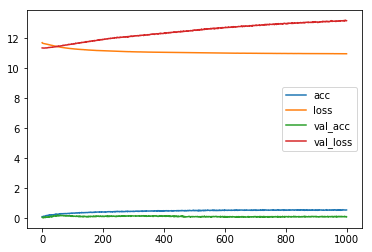

In [9]:
import matplotlib.pyplot as plt
for key, val in History.history.iteritems():
    plt.plot(val, label=key)
plt.legend()
plt.show()